In [23]:
# files loading
import os

from random import shuffle
import numpy as np

from tqdm import tqdm # progress bar


In [24]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image

In [25]:
# libraries for a CNN
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import timeit

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In [26]:
from tensorflow import keras
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [27]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

In [28]:
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [47]:
IMAGES_DIR = '../data/fotos_perros/train'

In [48]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


Bernese Mountain Dog
ipykernel_launcher:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


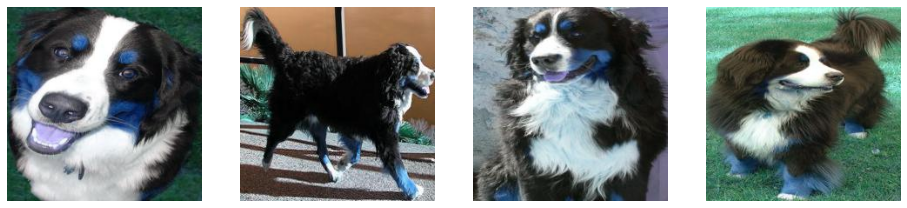

In [31]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = IMAGES_DIR + "/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[11])
show_dir_images(breed_list[11], 4)

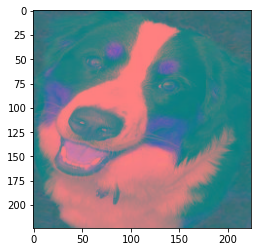

In [32]:
img_dir = IMAGES_DIR + "/{}/".format(breed_list[11])
images = os.listdir(img_dir)[:12]
images = os.listdir(img_dir)[:4]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)

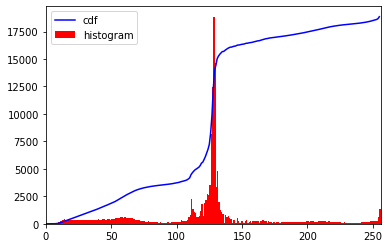

In [33]:
hist,bins = np.histogram(img_to_yuv.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [44]:
x_train.shape

(1080, 227, 227, 3)

In [34]:
img_to_yuv.shape

(224, 224, 3)

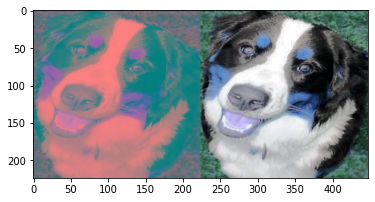

In [35]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

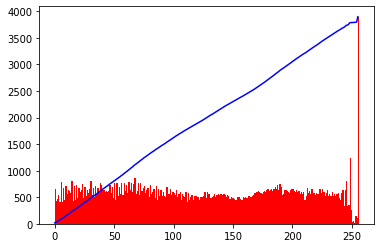

In [36]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

Augmented by rotation:


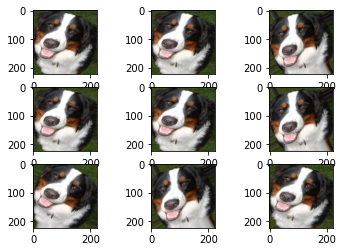

<Figure size 720x720 with 0 Axes>

In [37]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

In [39]:
num_breeds = 15 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1500 
No. of labels loaded =  1500
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

In [18]:
labels

array([ 0,  0,  0, ..., 14, 14, 14])

In [19]:
#step 1 - get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("10 'n' values before shuffling = ",n[:10])

#shuffle all the equally spaced values in list 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 'n' values after shuffling = ",n[:10])

10 'n' values before shuffling =  [0 1 2 3 4 5 6 7 8 9]
10 'n' values after shuffling =  [1116 1368  422  413  451  861 1063  741 1272  259]


In [20]:
#step 2 - shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)
print('same shapes before and after shuffling')

Images shape after shuffling =  (1500, 227, 227, 3) 
Labels shape after shuffling =  (1500,)
same shapes before and after shuffling


In [46]:
images.shape

(1500, 227, 227, 3)

In [21]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

In [22]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1080, 227, 227, 3)
y_train shape =  (1080,)

x_val shape =  (120, 227, 227, 3)
y_val shape =  (120,)

x_test shape =  (300, 227, 227, 3)
y_test shape =  (300,)
